In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM


2025-05-02 09:59:02.298 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

# Always specify a random state, otherwise the split will be different each time 
# If you have intention to load a model mid-training, you may have part of the validation set as already seen in the previous training
train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=42)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "amoonguss"
start_epoch=1
num_epochs=80
save_every=5
backup_every=20

# Model Hyper-parameters
head_layers=5
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=1

# Training Hyper-parameters
batch_size=128
lr=1e-3
momentum=0.0
weight_decay=0.0
dampening=0.0
T_max=30
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
optimizer = SGD(
    model.parameters(), 
    lr=lr,
    momentum=momentum,
    dampening=dampening,
    weight_decay=weight_decay
    )
scheduler = CosineAnnealingLR(
    optimizer=optimizer, 
    T_max=T_max, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# ---- RESUME ----

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 20
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

# -----------------

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 13, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: amoonguss



Training progress: 100%|██████████| 313/313 [01:24<00:00,  3.69batch/s]


🚀 Epoch 1/80 (1.25%) Completed
	📊 Training Loss: 4.3726
	✅ Training Accuracy: 6.04%
	⏳ Elapsed Time: 84.82s | ETA: 6700.89s
	🕒 Completed At: 10:00


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.95batch/s]


🔍 Validation Results:
	📉 Validation Loss: 3.7967
	🎯 Validation Accuracy: 15.37%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.64batch/s]


🚀 Epoch 2/80 (2.50%) Completed
	📊 Training Loss: 2.8357
	✅ Training Accuracy: 34.33%
	⏳ Elapsed Time: 85.93s | ETA: 6702.18s
	🕒 Completed At: 10:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 2.0970
	🎯 Validation Accuracy: 48.10%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 3/80 (3.75%) Completed
	📊 Training Loss: 1.7155
	✅ Training Accuracy: 54.74%
	⏳ Elapsed Time: 86.88s | ETA: 6689.94s
	🕒 Completed At: 10:04


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.14batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.5949
	🎯 Validation Accuracy: 56.96%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.68batch/s]


🚀 Epoch 4/80 (5.00%) Completed
	📊 Training Loss: 1.3422
	✅ Training Accuracy: 62.77%
	⏳ Elapsed Time: 85.03s | ETA: 6461.97s
	🕒 Completed At: 10:05


Eval progress: 100%|██████████| 79/79 [00:30<00:00,  2.60batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.4939
	🎯 Validation Accuracy: 58.18%



Training progress: 100%|██████████| 313/313 [01:36<00:00,  3.25batch/s]


🚀 Epoch 5/80 (6.25%) Completed
	📊 Training Loss: 1.1592
	✅ Training Accuracy: 67.25%
	⏳ Elapsed Time: 96.40s | ETA: 7230.22s
	🕒 Completed At: 10:07


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.3995
	🎯 Validation Accuracy: 61.46%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.68batch/s]


🚀 Epoch 6/80 (7.50%) Completed
	📊 Training Loss: 1.0282
	✅ Training Accuracy: 70.41%
	⏳ Elapsed Time: 85.16s | ETA: 6302.06s
	🕒 Completed At: 10:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.2010
	🎯 Validation Accuracy: 66.14%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.67batch/s]


🚀 Epoch 7/80 (8.75%) Completed
	📊 Training Loss: 0.9375
	✅ Training Accuracy: 72.63%
	⏳ Elapsed Time: 85.31s | ETA: 6227.64s
	🕒 Completed At: 10:11


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.13batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1841
	🎯 Validation Accuracy: 66.29%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 8/80 (10.00%) Completed
	📊 Training Loss: 0.8612
	✅ Training Accuracy: 74.89%
	⏳ Elapsed Time: 86.92s | ETA: 6258.37s
	🕒 Completed At: 10:13


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0787
	🎯 Validation Accuracy: 69.65%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 9/80 (11.25%) Completed
	📊 Training Loss: 0.8003
	✅ Training Accuracy: 76.43%
	⏳ Elapsed Time: 86.49s | ETA: 6140.58s
	🕒 Completed At: 10:14


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0670
	🎯 Validation Accuracy: 69.29%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.66batch/s]


🚀 Epoch 10/80 (12.50%) Completed
	📊 Training Loss: 0.7486
	✅ Training Accuracy: 77.98%
	⏳ Elapsed Time: 85.60s | ETA: 5991.77s
	🕒 Completed At: 10:16


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0500
	🎯 Validation Accuracy: 69.88%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 11/80 (13.75%) Completed
	📊 Training Loss: 0.7010
	✅ Training Accuracy: 79.14%
	⏳ Elapsed Time: 86.14s | ETA: 5943.45s
	🕒 Completed At: 10:18


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.13batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0180
	🎯 Validation Accuracy: 71.00%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 12/80 (15.00%) Completed
	📊 Training Loss: 0.6545
	✅ Training Accuracy: 80.65%
	⏳ Elapsed Time: 85.69s | ETA: 5826.71s
	🕒 Completed At: 10:20


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0171
	🎯 Validation Accuracy: 70.62%



Training progress: 100%|██████████| 313/313 [01:25<00:00,  3.65batch/s]


🚀 Epoch 13/80 (16.25%) Completed
	📊 Training Loss: 0.6205
	✅ Training Accuracy: 81.58%
	⏳ Elapsed Time: 85.82s | ETA: 5750.22s
	🕒 Completed At: 10:21


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9645
	🎯 Validation Accuracy: 72.08%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 14/80 (17.50%) Completed
	📊 Training Loss: 0.5795
	✅ Training Accuracy: 83.02%
	⏳ Elapsed Time: 87.59s | ETA: 5780.68s
	🕒 Completed At: 10:23


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9806
	🎯 Validation Accuracy: 71.87%



Training progress: 100%|██████████| 313/313 [01:30<00:00,  3.45batch/s]


🚀 Epoch 15/80 (18.75%) Completed
	📊 Training Loss: 0.5501
	✅ Training Accuracy: 83.61%
	⏳ Elapsed Time: 90.81s | ETA: 5902.44s
	🕒 Completed At: 10:25


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.88batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9728
	🎯 Validation Accuracy: 72.23%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_15.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:30<00:00,  3.46batch/s]


🚀 Epoch 16/80 (20.00%) Completed
	📊 Training Loss: 0.5227
	✅ Training Accuracy: 84.43%
	⏳ Elapsed Time: 90.53s | ETA: 5794.04s
	🕒 Completed At: 10:27


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.82batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9714
	🎯 Validation Accuracy: 72.58%



Training progress: 100%|██████████| 313/313 [01:32<00:00,  3.38batch/s]


🚀 Epoch 17/80 (21.25%) Completed
	📊 Training Loss: 0.4977
	✅ Training Accuracy: 85.46%
	⏳ Elapsed Time: 92.47s | ETA: 5825.90s
	🕒 Completed At: 10:29


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9355
	🎯 Validation Accuracy: 73.39%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 18/80 (22.50%) Completed
	📊 Training Loss: 0.4773
	✅ Training Accuracy: 85.99%
	⏳ Elapsed Time: 86.80s | ETA: 5381.45s
	🕒 Completed At: 10:31


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9488
	🎯 Validation Accuracy: 73.34%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 19/80 (23.75%) Completed
	📊 Training Loss: 0.4554
	✅ Training Accuracy: 86.80%
	⏳ Elapsed Time: 87.60s | ETA: 5343.83s
	🕒 Completed At: 10:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9338
	🎯 Validation Accuracy: 73.59%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.54batch/s]


🚀 Epoch 20/80 (25.00%) Completed
	📊 Training Loss: 0.4392
	✅ Training Accuracy: 87.48%
	⏳ Elapsed Time: 88.33s | ETA: 5299.57s
	🕒 Completed At: 10:34


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9195
	🎯 Validation Accuracy: 73.96%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250502_103457_amoonguss_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250502_103458_amoonguss_BaseDino_epoch_20.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 21/80 (26.25%) Completed
	📊 Training Loss: 0.4229
	✅ Training Accuracy: 87.81%
	⏳ Elapsed Time: 87.28s | ETA: 5149.42s
	🕒 Completed At: 10:36


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.94batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9157
	🎯 Validation Accuracy: 74.08%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 22/80 (27.50%) Completed
	📊 Training Loss: 0.4043
	✅ Training Accuracy: 88.49%
	⏳ Elapsed Time: 87.38s | ETA: 5067.83s
	🕒 Completed At: 10:38


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9130
	🎯 Validation Accuracy: 74.35%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 23/80 (28.75%) Completed
	📊 Training Loss: 0.3925
	✅ Training Accuracy: 88.89%
	⏳ Elapsed Time: 86.64s | ETA: 4938.25s
	🕒 Completed At: 10:39


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9126
	🎯 Validation Accuracy: 74.19%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 24/80 (30.00%) Completed
	📊 Training Loss: 0.3815
	✅ Training Accuracy: 89.33%
	⏳ Elapsed Time: 86.96s | ETA: 4869.57s
	🕒 Completed At: 10:41


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9174
	🎯 Validation Accuracy: 74.31%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 25/80 (31.25%) Completed
	📊 Training Loss: 0.3776
	✅ Training Accuracy: 89.50%
	⏳ Elapsed Time: 86.91s | ETA: 4779.94s
	🕒 Completed At: 10:43


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.45batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9061
	🎯 Validation Accuracy: 74.65%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_25.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_25.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.53batch/s]


🚀 Epoch 26/80 (32.50%) Completed
	📊 Training Loss: 0.3700
	✅ Training Accuracy: 89.80%
	⏳ Elapsed Time: 88.76s | ETA: 4793.00s
	🕒 Completed At: 10:45


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9067
	🎯 Validation Accuracy: 74.16%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 27/80 (33.75%) Completed
	📊 Training Loss: 0.3645
	✅ Training Accuracy: 89.92%
	⏳ Elapsed Time: 86.65s | ETA: 4592.28s
	🕒 Completed At: 10:47


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9066
	🎯 Validation Accuracy: 74.47%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 28/80 (35.00%) Completed
	📊 Training Loss: 0.3639
	✅ Training Accuracy: 90.03%
	⏳ Elapsed Time: 86.29s | ETA: 4487.20s
	🕒 Completed At: 10:48


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9094
	🎯 Validation Accuracy: 74.37%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 29/80 (36.25%) Completed
	📊 Training Loss: 0.3566
	✅ Training Accuracy: 90.32%
	⏳ Elapsed Time: 87.21s | ETA: 4447.64s
	🕒 Completed At: 10:50


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9099
	🎯 Validation Accuracy: 74.44%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 30/80 (37.50%) Completed
	📊 Training Loss: 0.3534
	✅ Training Accuracy: 90.48%
	⏳ Elapsed Time: 86.35s | ETA: 4317.41s
	🕒 Completed At: 10:52


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9018
	🎯 Validation Accuracy: 74.55%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_30.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/amoonguss_BaseDino_epoch_30.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 31/80 (38.75%) Completed
	📊 Training Loss: 0.3583
	✅ Training Accuracy: 90.22%
	⏳ Elapsed Time: 86.22s | ETA: 4224.84s
	🕒 Completed At: 10:54


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9090
	🎯 Validation Accuracy: 74.41%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 32/80 (40.00%) Completed
	📊 Training Loss: 0.3584
	✅ Training Accuracy: 90.19%
	⏳ Elapsed Time: 86.54s | ETA: 4153.68s
	🕒 Completed At: 10:56


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8967
	🎯 Validation Accuracy: 74.55%



Training progress:  63%|██████▎   | 197/313 [00:55<00:32,  3.57batch/s]

Training interrupted manually.


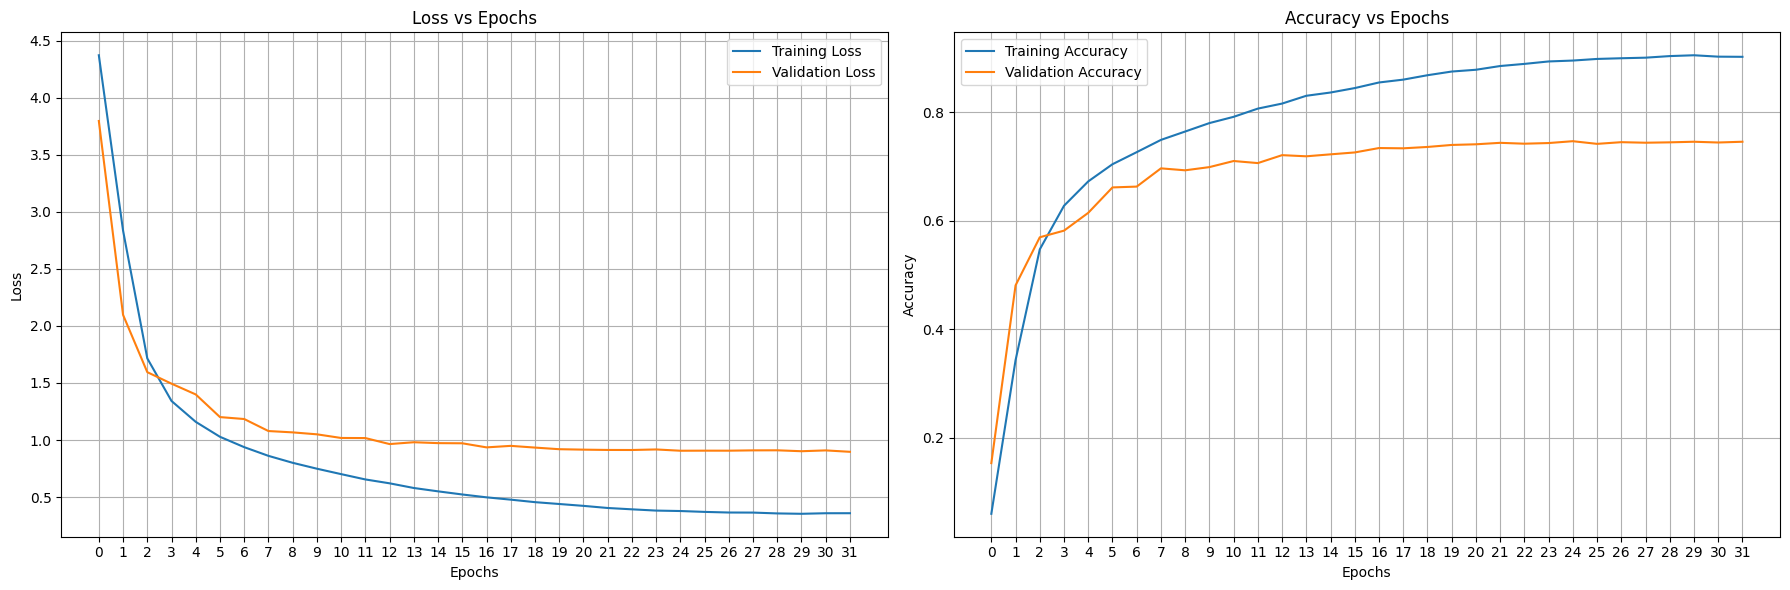

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_losses)), rotation=0)  # Rotate ticks by 20 degrees

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_accuracies)), rotation=0)  # Rotate ticks by 20 degrees

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.14batch/s]

🔍 Test Results:
	📉 Test Loss: 0.8725
	🎯 Test Accuracy: 74.72%
